In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# MNIST VAE

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 14, 14, 32)           320       ['input_7[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_6[0][0]']            
                                                                                                  
 flatten_3 (Flatten)         (None, 3136)                 0         ['conv2d_7[0][0]']            
                                                                                            

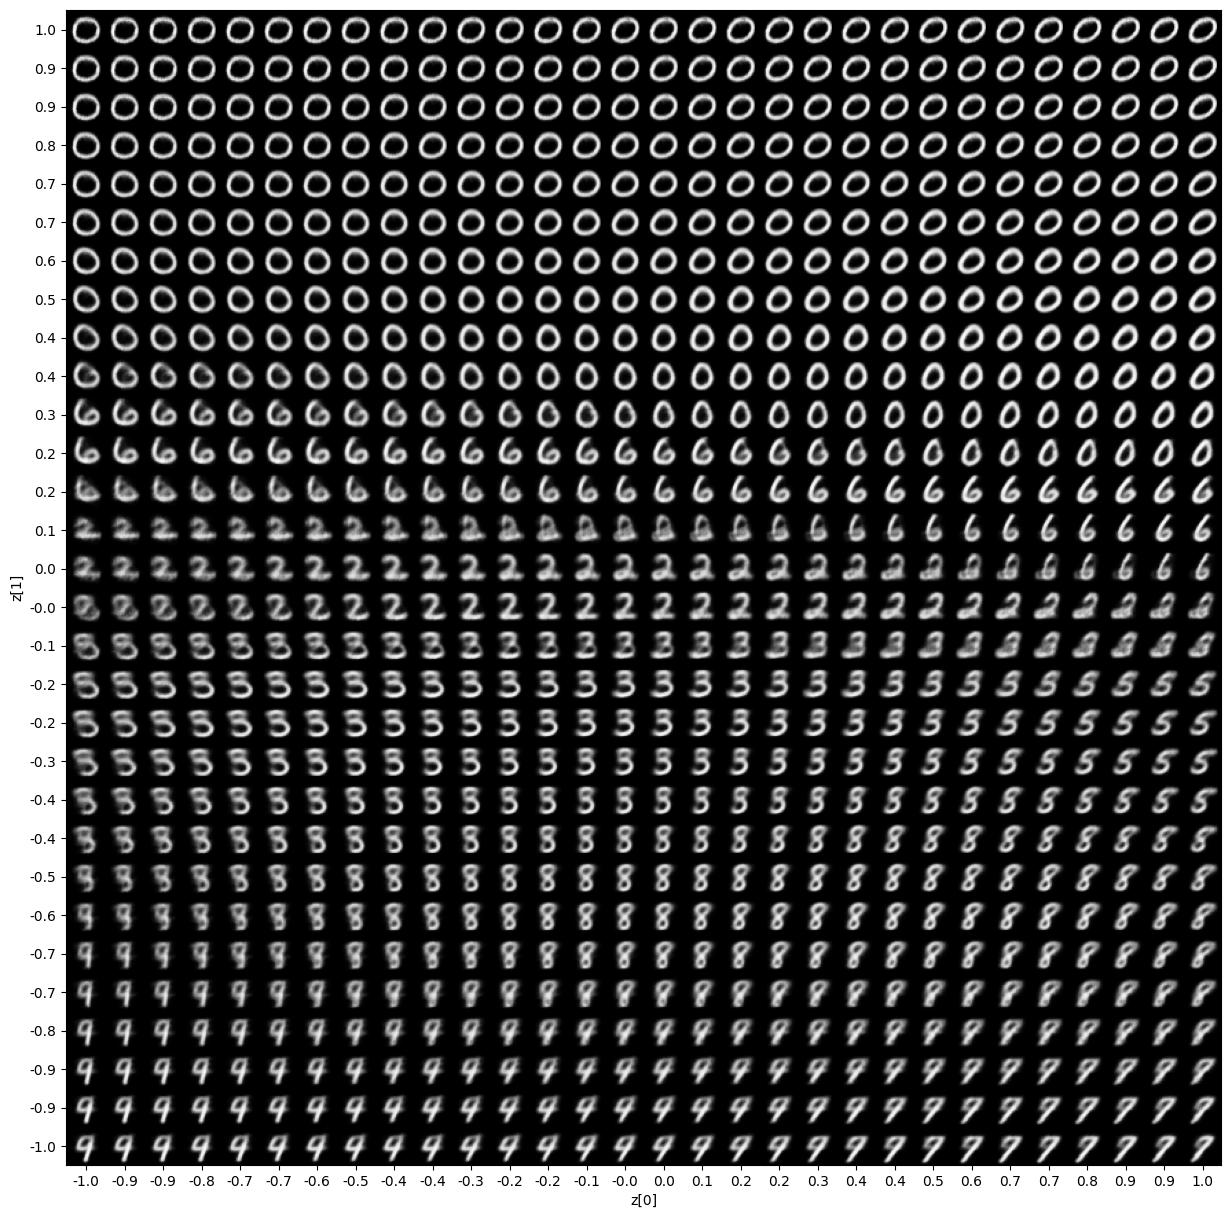

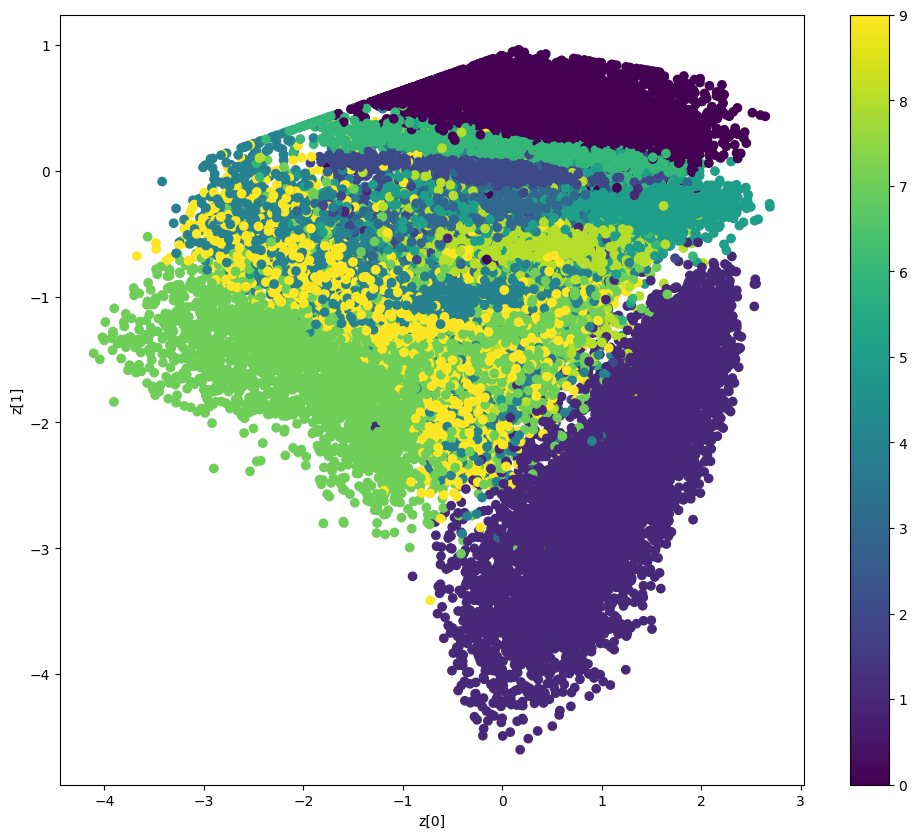

In [ ]:
"""
Title: Variational AutoEncoder
Author: [fchollet](https://twitter.com/fchollet)
Date created: 2020/05/03
Last modified: 2024/04/24
Description: Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.
Accelerator: GPU
"""

"""
## Setup
"""

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras import layers
"""
## Create a sampling layer
"""




class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = tf.random.Generator.from_seed(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = self.seed_generator.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


"""
## Build the encoder
"""

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

"""
## Define the VAE as a `Model` with a custom `train_step`
"""


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



"""
## Train the VAE
"""

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
print(mnist_digits.shape)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

"""
## Display a grid of sampled digits
"""

import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

"""
## Display how the latent space clusters different digit classes
"""


def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.*intersection+smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

# 하하맨

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from google.colab.patches import cv2_imshow
from keras import layers
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Input, MaxPooling2D, Add, BatchNormalization, LeakyReLU, Reshape, Flatten, Dense
from pylab import *
from keras.datasets import mnist
from keras.optimizers import Adam

In [ ]:
"""
## Setup
"""

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras import layers
"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = tf.random.Generator.from_seed(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = self.seed_generator.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


"""
## Build the encoder
"""

latent_dim = 2

encoder_inputs = keras.Input(shape=(256, 256, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64 * 64 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((64, 64, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


"""
## Define the VAE as a `Model` with a custom `train_step`
"""


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs, training=False):
      z_mean, z_log_var, z = self.encoder(inputs)
      reconstruction = self.decoder(z)
      return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

"""
## Train the VAE
"""
# train
# 폴더 경로
img_data_path = '/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal'

# 폴더 밑에 있는 영상 파일 이름들이 image_file_names에 들어감
image_file_names = os.listdir(img_data_path)

# 폴더 밑의 전체 영상 갯수
total = len(image_file_names)

imgsize = 256
image_rows = imgsize
image_cols = imgsize

imgs = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)

i = 0
print('-'*30)
print('Creating training images...')
print('-'*30)

for image_name in image_file_names:

    file_name = os.path.join(img_data_path, image_name)
    print (file_name)

    img = cv2.imread(file_name,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_cols, image_rows))
    imgs[i] = img
    i = i + 1

    # cv2_imshow(img)


# 결합된 total 개수의 영상 묶음을 저장
np.save('train.npy', imgs)

# 읽을 때는 다음과 같이
train_data = np.load('/content/train.npy')

# Test the VAE
# test
# 폴더 경로
img_data_path = '/content/drive/MyDrive/anomaly/Select'

# 폴더 밑에 있는 영상 파일 이름들이 image_file_names에 들어감
image_file_names = os.listdir(img_data_path)

# 폴더 밑의 전체 영상 갯수
total = len(image_file_names)

imgs = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)

i = 0
print('-'*30)
print('Creating training images...')
print('-'*30)

for image_name in image_file_names:

    file_name = os.path.join(img_data_path, image_name)
    print (file_name)

    img = cv2.imread(file_name,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_cols, image_rows))
    imgs[i] = img
    i = i + 1

    # cv2_imshow(img)


# 결합된 total 개수의 영상 묶음을 저장
np.save('test.npy', imgs)

# 읽을 때는 다음과 같이
test_data = np.load('/content/test.npy')

train_data = train_data.astype("float32") / 255.0
test_data = test_data.astype("float32") / 255.0

train_data = np.expand_dims(train_data, axis=-1)  # Now shape is (None, 256, 256, 1)
test_data = np.expand_dims(test_data, axis=-1)  # Now shape is (None, 256, 256, 1)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 32)   │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 262144)         │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 16)             │      4,194,320 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_2 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,213,204 (16.07 MB)

 Trainable params: 4,213,204 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 262144)              │         786,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 256, 256, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 256, 256, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 842,113 (3.21 MB)

 Trainable params: 842,113 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

------------------------------
Creating training images...
------------------------------
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (12).png
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (109).png
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (121).png
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (124).png
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (110).png
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (1).png
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (106).png
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (112).png
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (118).png
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (107).png
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (125).png
/content/drive/MyDrive/anomaly/Dataset_BUSI_with_GT/normal/normal (117).png
/

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

vae.fit(train_data, epochs=500, batch_size=128)

#모델 가시화

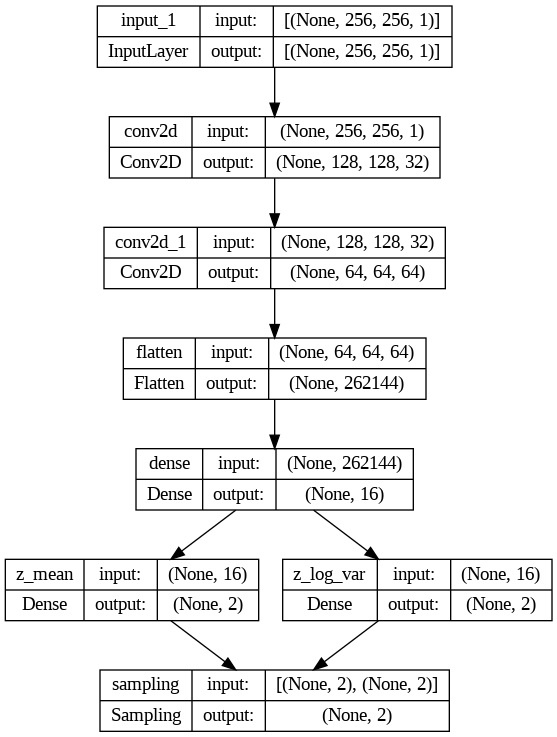

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(encoder)
plot_model(encoder, show_shapes=True)

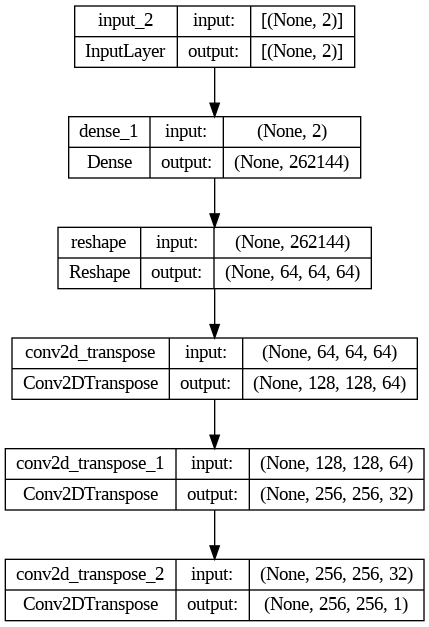

In [ ]:
plot_model(decoder)
plot_model(decoder, show_shapes=True)

In [ ]:
# def preprocess(array):
#     """Normalizes the supplied array and reshapes it."""
#     array = array.astype("float32") / 255.0
#     array = np.reshape(array, (len(array), image_rows, image_cols, 1))
#     return array


# # def noise(array):
# #     """Adds random noise to each image in the supplied array."""
# #     noise_factor = 0.4
# #     noisy_array = array + noise_factor * np.random.normal(
# #         loc=0.0, scale=1.0, size=array.shape
# #     )

# #     return np.clip(noisy_array, 0.0, 1.0)


# def display(array1, array2):
#     """Displays ten random images from each array."""
#     n = 10
#     indices = np.random.randint(len(array1), size=n)
#     images1 = array1[indices, :]
#     images2 = array2[indices, :]

#     plt.figure(figsize=(20, 4))
#     for i, (image1, image2) in enumerate(zip(images1, images2)):
#         ax = plt.subplot(2, n, i + 1)
#         plt.imshow(image1.reshape(image_rows, image_cols))
#         plt.gray()
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

#         ax = plt.subplot(2, n, i + 1 + n)
#         plt.imshow(image2.reshape(image_rows, image_cols))
#         plt.gray()
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

#     plt.show()

# def display_3(array1, array2, array3):
#     n = 10
#     indices = np.random.randint(len(array1), size=n)
#     images1 = array1[indices, :]
#     images2 = array2[indices, :]
#     images3 = array3[indices, :]
#     plt.figure(figsize=(30, 6))
#     for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
#         ax = plt.subplot(3, n, i + 1)
#         plt.imshow(image1.reshape(image_rows, image_cols))
#         plt.gray()
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

#         ax = plt.subplot(3, n, i + 1 + n)
#         plt.imshow(image2.reshape(image_rows, image_cols))
#         plt.gray()
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

#         ax = plt.subplot(3, n, i + 1 + n + n)
#         plt.imshow(image3.reshape(image_rows, image_cols))
#         plt.gray()
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

#     plt.show()

In [ ]:
def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), image_rows, image_cols, 1))
    return array


# def noise(array):
#     """Adds random noise to each image in the supplied array."""
#     noise_factor = 0.4
#     noisy_array = array + noise_factor * np.random.normal(
#         loc=0.0, scale=1.0, size=array.shape
#     )

#     return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(image_rows, image_cols))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(image_rows, image_cols))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def display_3(array1, array2, array3):
    n = 10
    images1 = array1[:, :]
    images2 = array2[:, :]
    images3 = array3[:, :]
    plt.figure(figsize=(30, 6))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1.reshape(image_rows, image_cols))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(image_rows, image_cols))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(image3.reshape(image_rows, image_cols))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


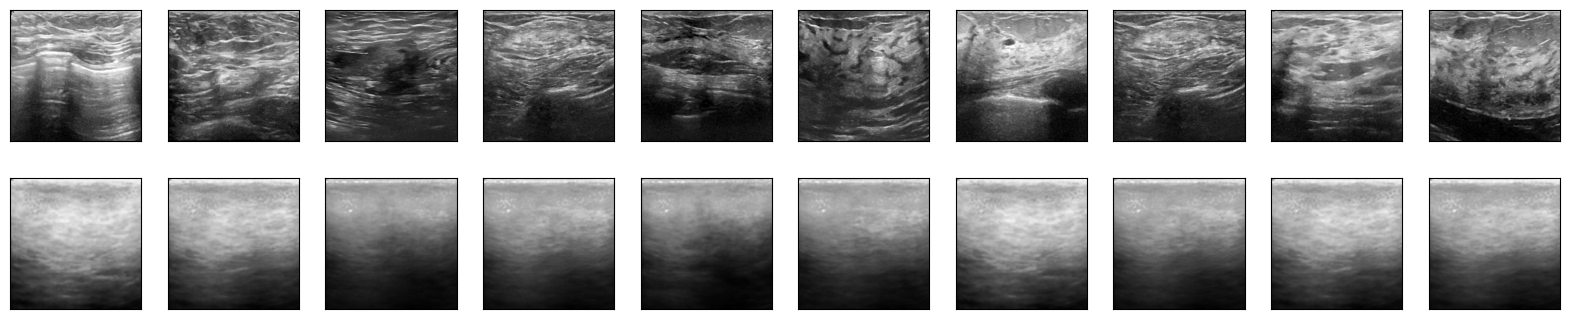

(133, 256, 256, 1)


In [ ]:
predictions = vae.predict(train_data)
display(train_data, predictions)
print(predictions.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


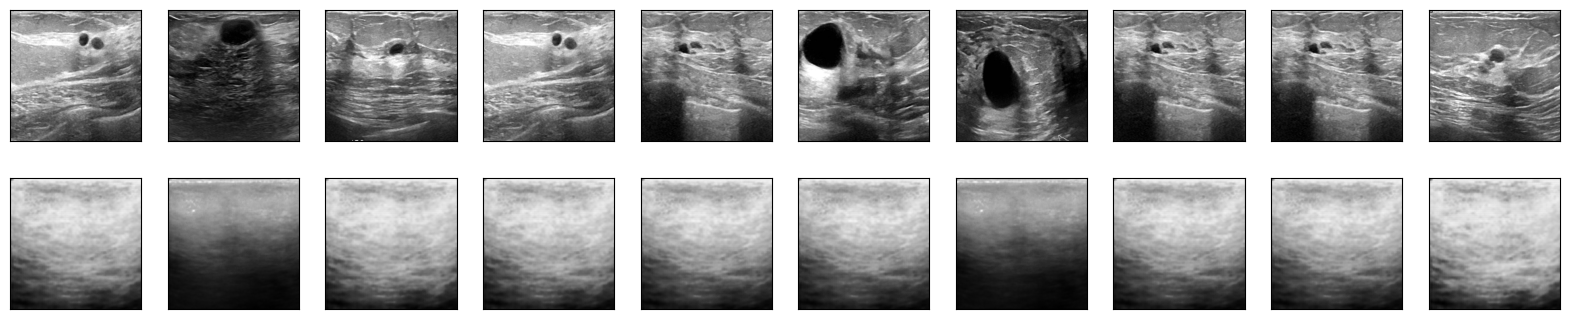

(10, 256, 256, 1)


In [ ]:
predictions1 = vae.predict(test_data)
display(test_data, predictions1)
print(predictions1.shape)

In [ ]:
# plot the train and validation loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Comparison of Train & Validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

(133, 256, 256, 1)
(133, 256, 256, 1)


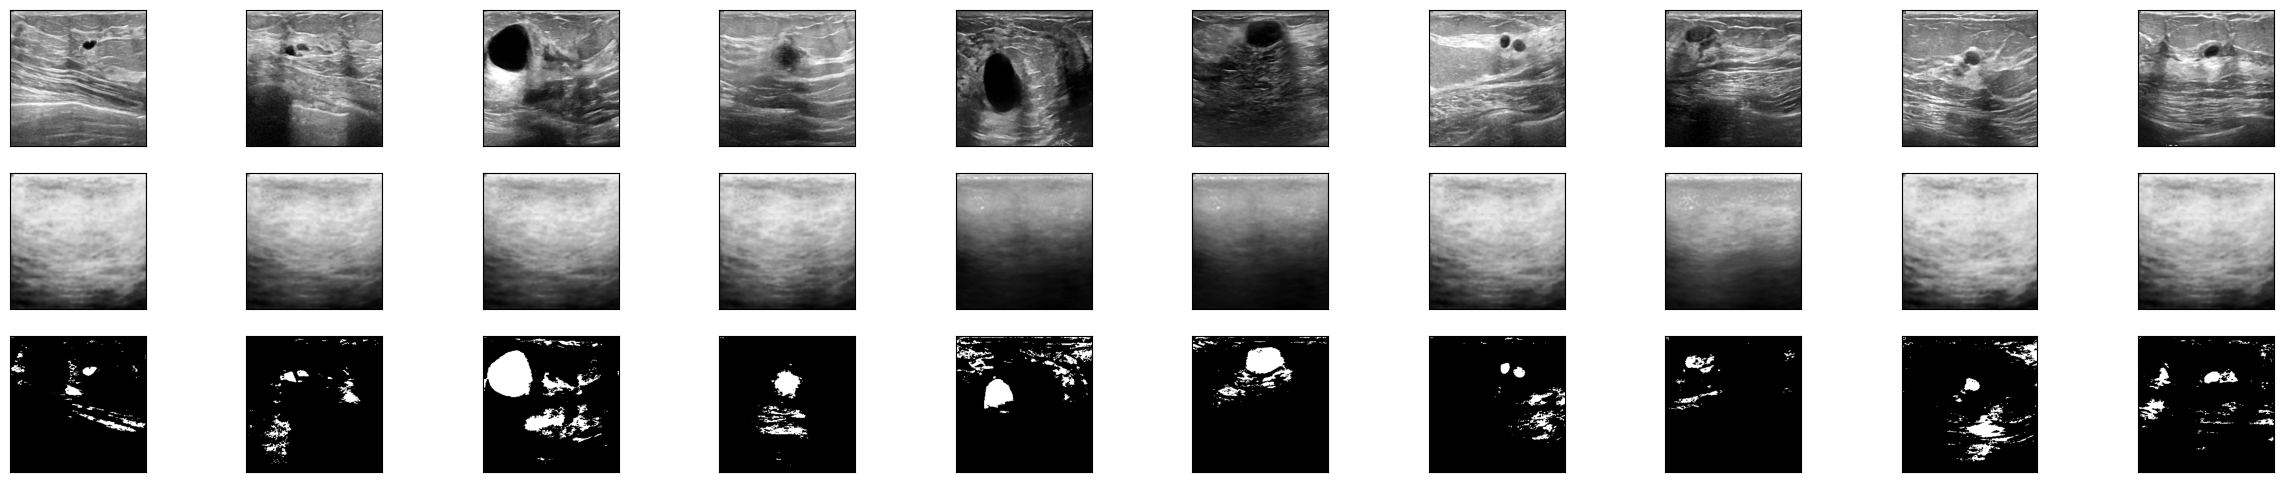

In [ ]:
# predictions = autoencoder.predict(train_data)
predictions = predictions.reshape(train_data.shape)
# predictions1 = autoencoder.predict(test_data)
predictions1 = predictions1.reshape(test_data.shape)

print(train_data.shape)
print(predictions.shape)

# img = (train_data - predictions)+100
img = (predictions - train_data)+0.781
img = img.astype('uint8')
#
img_1 = (predictions1 - test_data)+0.75
img_1 = img_1.astype('uint8')

# display(train_data, img)
# display_3(train_data,predictions,img)
# display(test_data,predictions1)
display_3(test_data,predictions1,img_1)

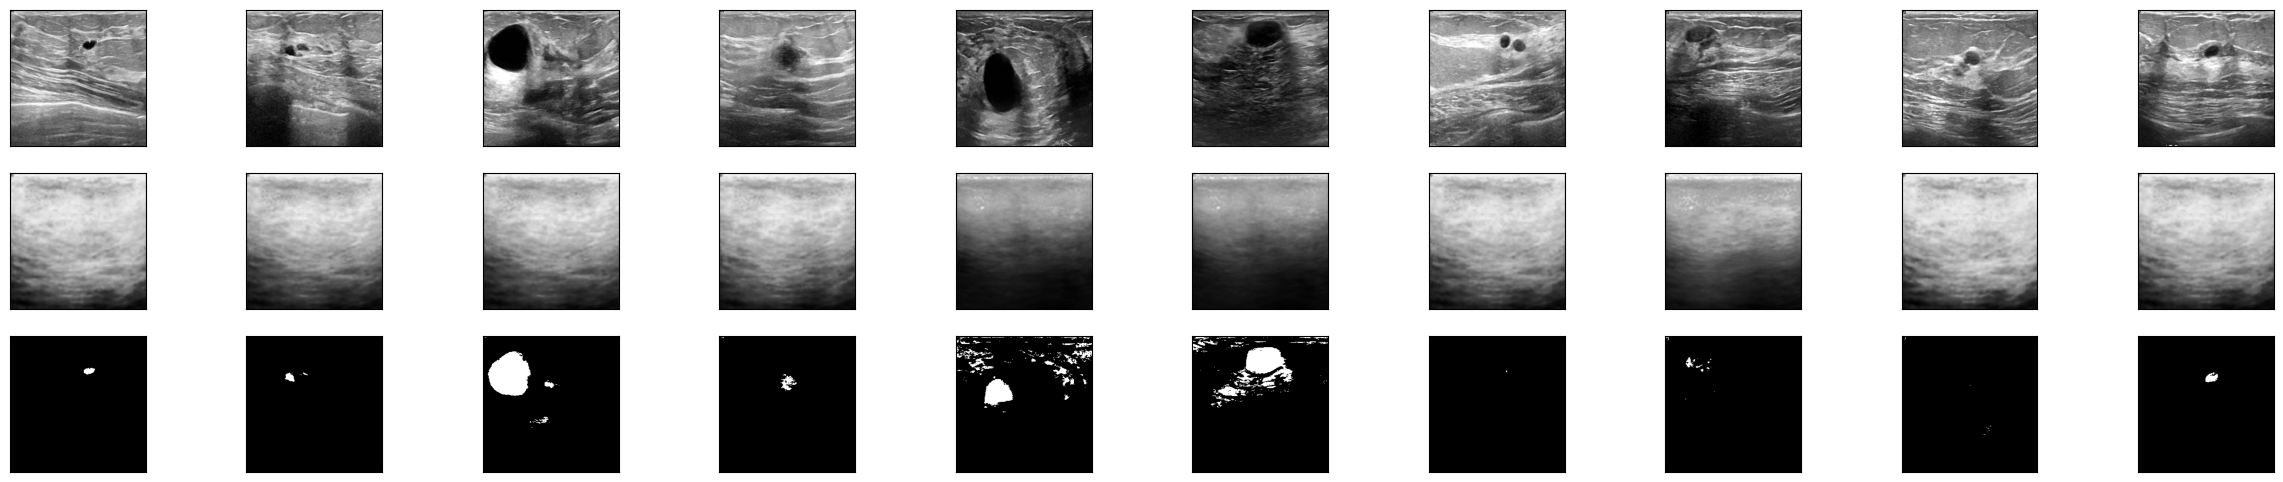

In [ ]:
# 동적 임계값 이진화 방법!!

def create_dynamic_threshold_image(original, reconstructed):
    """
    원본 이미지와 재구성된 이미지 간의 차이 이미지를 생성하고,
    각 이미지의 평균값을 기반으로 이진화합니다.
    """
    diff_image = reconstructed - original

    # 이미지마다 동적 임계값 계산 (이미지의 평균 밝기)
    dynamic_threshold = np.mean(original)

    # 동적 임계값을 사용하여 이진화
    binarized_image = np.where(diff_image > dynamic_threshold, 1.0, 0.0)

    # uint8 형식으로 변환 (0과 255)
    binarized_image = (binarized_image * 255).astype('uint8')

    return binarized_image

# 각 데이터셋에 대해 차이 이미지 생성 후 동적 이진화
img_diff_train_binarized = np.array([create_dynamic_threshold_image(o, r) for o, r in zip(train_data, predictions)])
img_diff_test_binarized = np.array([create_dynamic_threshold_image(o, r) for o, r in zip(test_data, predictions1)])

# 시각화
display_3(test_data, predictions1, img_diff_test_binarized)

#dice_coef

In [ ]:
############

import os
import cv2
import numpy as np

# Dice Coefficient 계산 함수
def dice_coefficient(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-7)

# 마스크 이미지 경로
mask_images_path = "/content/drive/MyDrive/anomaly/Select_Mask"
mask_image_files = sorted(os.listdir(mask_images_path))

# 예측 이미지를 동적 이진화하여 생성하는 부분
predictions = []
for img in test_data:  # test_data는 전처리된 원본 이미지들입니다.
    # 동적 임계값 이진화 적용
    mean_pixel_value = np.mean(img)
    binary_img = np.where(img >= mean_pixel_value, 1, 0)
    predictions.append(binary_img)

# Dice Coefficient 계산 및 출력
dice_scores = []

for i, mask_file in enumerate(mask_image_files):
    mask_path = os.path.join(mask_images_path, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # 마스크 이미지를 예측된 이미지와 동일한 크기로 변경
    mask_resized = cv2.resize(mask, (test_data.shape[2], test_data.shape[1]))

    # 이진화된 마스크 이미지를 0 또는 1로 스케일링
    _, mask_binary = cv2.threshold(mask_resized, 127, 1, cv2.THRESH_BINARY)

    # 동적 이진화된 예측 이미지 가져오기
    prediction_binary = predictions[i]

    # Dice Coefficient 계산
    dice = dice_coefficient(mask_binary, prediction_binary)
    dice_scores.append(dice)

    print(f"Image {i + 1} ({os.path.basename(mask_file)}) Dice Coefficient: {dice:.4f}")

# 평균 Dice Coefficient 계산
mean_dice_coefficient = np.mean(dice_scores)
print(f"Mean Dice Coefficient: {mean_dice_coefficient:.4f}")

#########

Image 1 (benign (121).png) Dice Coefficient: 0.0772
Image 2 (benign (153).png) Dice Coefficient: 0.0224
Image 3 (benign (154).png) Dice Coefficient: 0.0233
Image 4 (benign (167).png) Dice Coefficient: 0.0000
Image 5 (benign (187).png) Dice Coefficient: 0.0439
Image 6 (benign (190).png) Dice Coefficient: 0.0423
Image 7 (benign (327).png) Dice Coefficient: 0.2781
Image 8 (benign (328).png) Dice Coefficient: 0.0255
Image 9 (malignant (73).png) Dice Coefficient: 0.1214
Image 10 (malignant (92).png) Dice Coefficient: 0.1704
Mean Dice Coefficient: 0.0804


In [ ]:
import numpy as np
import cv2

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# 마스크 이미지 불러오기 (업로드된 이미지를 사용한다고 가정)
# img_path에는 마스크 이미지 경로를 넣어야 함.
true_mask_path = '/mnt/data/true_mask.png'  # 실제 마스크 경로
predicted_mask_path = '/mnt/data/predicted_mask.png'  # 예측된 마스크 경로

# 이미지를 이진화된 마스크로 로드 (0 또는 1 값으로 이진화)
true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)

# 이진화: 픽셀 값이 128 이상이면 1, 아니면 0
_, true_mask_bin = cv2.threshold(true_mask, 128, 1, cv2.THRESH_BINARY)
_, predicted_mask_bin = cv2.threshold(predicted_mask, 128, 1, cv2.THRESH_BINARY)

# Dice coefficient 계산
dice_score = dice_coef(true_mask_bin, predicted_mask_bin)
print(f"Dice Coefficient: {dice_score}")
